## Índice
[OBTER SEQUENCIAS](#OBTER-SEQUENCIAS)\
[OBTER SMILES](#OBTER-SMILES)\
[AJUSTES](#AJUSTES)\
[Visualização](#Visualização)

In [6]:
import pandas as pd
import requests
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
data = pd.read_table('data/sabio_rk/sabioExport.tsv')

In [86]:
[x for x in data['parameter.associatedSpecies'] if ',' in str (x)]

['1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'L-695,256',
 'L-695,256',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'LJC 10,627',
 'LJC 10,627',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 'Naphthalene-2,3-diol',
 'Vanadate-Naphthalene-2,3-diol complex',
 'Vanadate-Naphthalene-

In [88]:
print(data.shape)
print(30*'-')
print(data.isna().sum())
print(30*'-')
print(data.isnull().sum())

(9951, 23)
------------------------------
Enzyme Variant                    0
Enzymename                        0
EntryID                           0
Reaction                          0
ECNumber                          0
UniProtKB_AC                    715
Organism                          0
Temperature                       0
pH                                0
Inhibitor                      8607
KineticMechanismType              0
parameter.name                    0
parameter.type                    0
parameter.associatedSpecies    2114
parameter.startValue           2801
parameter.endValue             9198
parameter.standardDeviation       0
parameter.unit                    0
Product                           0
PubMedID                          0
Publication                       0
SabioReactionID                   1
Substrate                         1
dtype: int64
------------------------------
Enzyme Variant                    0
Enzymename                        0
EntryID       

In [89]:
(data['parameter.name'].nunique())

58

In [90]:
data['parameter.name'] = data['parameter.name'].astype(str).str.lower()
data['parameter.name'].nunique()

55

In [93]:
data.head()

,Enzyme Variant,Enzymename,EntryID,Reaction,ECNumber,UniProtKB_AC,Organism,Temperature,pH,Inhibitor,KineticMechanismType,parameter.name,parameter.type,parameter.associatedSpecies,parameter.startValue,parameter.endValue,parameter.standardDeviation,parameter.unit,Product,PubMedID,Publication,SabioReactionID,Substrate
0,wildtype,beta-lactamase,247,Penicillin G + H2O = Substituted beta-amino acid,3.5.2.6,P29723,Treponema pallidum,22.0,7.4,NaN,Michaelis-Menten,kcat/km,kcat/Km,Penicillin G,1.600000e-05,NaN,1E-6,M^(-1)*s^(-1),Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,Penicillin G;H2O
1,wildtype,beta-lactamase,247,Penicillin G + H2O = Substituted beta-amino acid,3.5.2.6,P29723,Treponema pallidum,22.0,7.4,NaN,Michaelis-Menten,km,Km,Penicillin G,3.640000e-05,NaN,-,M,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,Penicillin G;H2O
2,wildtype,beta-lactamase,247,Penicillin G + H2O = Substituted beta-amino acid,3.5.2.6,P29723,Treponema pallidum,22.0,7.4,NaN,Michaelis-Menten,e,concentration,Enzyme,2.000000e-08,NaN,-,M,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,Penicillin G;H2O
3,wildtype,beta-lactamase,247,Penicillin G + H2O = Substituted beta-amino acid,3.5.2.6,P29723,Treponema pallidum,22.0,7.4,NaN,Michaelis-Menten,kcat,kcat,NaN,5.900000e+00,NaN,3E-1,s^(-1),Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,Penicillin G;H2O
4,wildtype,beta-lactamase,247,Penicillin G + H2O = Substituted beta-amino acid,3.5.2.6,P29723,Treponema pallidum,22.0,7.4,NaN,Michaelis-Menten,s,concentration,Penicillin G,2.000000e-06,0.00005,-,M,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,Penicillin G;H2O


In [91]:
# Primeiro: separa só o que interessa pro pivot
parametros = data[['EntryID', 'parameter.name', 'parameter.startValue']]

pivoted_params = (
    parametros.pivot_table(
        index='EntryID',
        columns='parameter.name',
        values='parameter.startValue',
        aggfunc='first'
    )
    .reset_index()
)

In [92]:
pivoted_params.head()

parameter.name,EntryID,a,act,b,c,co,e,i,i1,i2,ic50,ic50_clavulanic_acid,ic50_sulbactam,ic50_tazobactam,ic_50,k,k1,k2,k2_k_2,k3,k4,k_2,k_inact,kcat,kcat/km,kcat_a,kcat_b,kcat_c,kcat_d,kcat_ki,kcat_kinact,kcat_km,kd,ki,ki_lim,kinact,kinact_ki,kistar,km,kma,kmax,kmb,kmc,kmd,kminus1,kminus2,ks,ksi,m,s,v,vmax,vmax_km,zn
0,247,NaN,NaN,NaN,NaN,NaN,2.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN
1,248,NaN,NaN,NaN,NaN,NaN,2.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.7,0.000060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN
2,249,NaN,NaN,NaN,NaN,NaN,2.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN
3,250,NaN,NaN,NaN,NaN,NaN,2.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN
4,251,NaN,NaN,NaN,NaN,NaN,2.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,890.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN


In [95]:
pivoted_params.shape

(2337, 54)

In [96]:
meta = data.groupby('EntryID', as_index=False).agg({
    'EntryID': 'first',
    'pH': 'first',
    'Temperature': 'first',
    # 'kcat_km': 'first',
    # 'kcat': 'first',
    # 'km': 'first',
    # 'kcat/km': 'first',
    'Organism': 'first',
    'Enzyme Variant': 'first',
    'Enzymename': 'first',
    'Substrate': 'first',
    'Reaction': 'first',
    'Product': 'first',
    'PubMedID': 'first',
    'Publication': 'first',
    'SabioReactionID': 'first',
    'UniProtKB_AC':'first',
    'parameter.associatedSpecies':'first',
})

df_final = meta.merge(pivoted_params, on='EntryID', how='left')

In [97]:
df_final.isna().sum()

EntryID                           0
pH                                0
Temperature                       0
Organism                          0
Enzyme Variant                    0
Enzymename                        0
Substrate                         1
Reaction                          0
Product                           0
PubMedID                          0
Publication                       0
SabioReactionID                   1
UniProtKB_AC                    213
parameter.associatedSpecies      12
a                              1677
act                            2336
b                              2331
c                              2154
co                             2321
e                              2041
i                              2261
i1                             2307
i2                             2307
ic50                           2202
ic50_clavulanic_acid           2334
ic50_sulbactam                 2334
ic50_tazobactam                2334
ic_50                       

In [101]:
df_final = df_final[['EntryID',
                    'pH',
                    'Temperature',
                    'kcat_km',
                    'kcat',
                    'km',
                    'kcat/km',
                    'Organism',
                    'Enzyme Variant',
                    'Enzymename',
                    'Substrate',
                    'Reaction',
                    'Product',
                    'PubMedID',
                    'Publication',
                    'SabioReactionID',
                    'UniProtKB_AC',
                    'parameter.associatedSpecies']]

In [102]:
df_final.isna().sum()

EntryID                           0
pH                                0
Temperature                       0
kcat_km                         870
kcat                            739
km                              618
kcat/km                        2299
Organism                          0
Enzyme Variant                    0
Enzymename                        0
Substrate                         1
Reaction                          0
Product                           0
PubMedID                          0
Publication                       0
SabioReactionID                   1
UniProtKB_AC                    213
parameter.associatedSpecies      12
dtype: int64

In [105]:
[x for x in df_final['parameter.associatedSpecies'] if ',' in str(x)]

['1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'L-695,256',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'LJC 10,627',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 'Naphthalene-2,3-diol',
 'Vanadate-Naphthalene-1,2-diol complex',
 'Vanadate-3,4,5,6-Tetrafluorobenzene-1,2-diol complex',
 'Vanadate-2-(3,4-Dihydroxyphenyl)acetate complex',
 '2,3-Dihydroxynaphthalene-1,4-dione',
 'Vanadate-Naphthalene-2,3-diol complex',
 'Biphenyl-3,4-diol',
 '3,4-Dihydroxybenzoate',
 '4-Nitrobenzene-1,2-diol',
 'Naphthalene-2,3-diol',
 'Vanadate-Biphenyl-3,4-diol complex',
 '2-Ethylthio-(6S,8R)hydroxyethylpeneme',
 '2-Ethylthio-(6S,8R)hydroxyethylpeneme']

In [106]:
df_final.to_csv('data/sabio_rk/composite_data_sabiork.csv')

In [107]:
df_final.shape

(2338, 18)

### XML

In [92]:
d = 'data/sabio_rk/xml2'
os.makedirs(d, exist_ok=True)

In [ ]:
# DONE
for entry_id in data.EntryID:
    url = f"https://sabiork.h-its.org/sabioRestWebServices/kineticLaws/{entry_id}"
    params = {"format": "sbml"}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        with open(f"{d}/{entry_id}.xml", "w", encoding="utf-8") as f:
            f.write(response.text)
    else:
        print(f"Erro no ID {entry_id}: {response.status_code}")

### Extração

In [90]:
import xml.etree.ElementTree as ET

#path = f"{d}/247.xml"
XML_DIR = d

# Namespaces usados no SBML
NS = {
    'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
    'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'sbrk': 'http://sabiork.h-its.org',
}

def parse_sbml(filepath):
    """Lê um arquivo SBML do SABIO-RK e extrai parâmetros principais"""
    tree = ET.parse(filepath)
    root = tree.getroot()

    # Id basico
    entry_id = os.path.basename(filepath).replace(".xml", "")
    model = root.find(".//sbml:model", NS)
    model_name = model.attrib.get("name") if model is not None else None

    # ENZIMA
    enzyme_name, uniprot_id = None, None
    for species in root.findall(".//sbml:species", NS):
        name = species.attrib.get("name", "")
        if "lactamase" in name.lower():
            enzyme_name = name
            # procurar UniprotID
            for li in species.findall(".//rdf:li", NS):
                link = li.attrib.get("rdf:resource", "")
                if "uniprot" in link:
                    uniprot_id = link.split("/")[-1]
                    break

    # SUBSTRATO
    substrate_name = None
    for species in root.findall(".//sbml:species", NS):
        name = species.attrib.get("name", "")
        if "enzyme" not in name.lower():
            # pega o primeiro que não for enzima
            substrate_name = name
            break

    # PARÂMETROS CINÉTICOS
    kcat = km = kcat_km = None
    for param in root.findall(".//sbml:localParameter", NS):
        pname = param.attrib.get("name", "").lower()
        value = float(param.attrib.get("value", "nan"))
        if "kcatdivkm" in pname or "kcat/km" in pname:
            kcat_km = value
        elif pname.startswith("km"):
            km = value
        elif pname.startswith("kcat"):
            kcat = value

    # CONDIÇÕES EXPERIMENTAIS
    temperature = None
    ph = None
    for val in root.findall(".//sbrk:startValueTemperature", NS):
        try:
            temperature = float(val.text)
        except:
            pass
    for val in root.findall(".//sbrk:startValuepH", NS):
        try:
            ph = float(val.text)
        except:
            pass

    # --- REFERÊNCIA (PubMed ID) ---
    pubmed_id = None
    for li in root.findall(".//rdf:li", NS):
        link = li.attrib.get("rdf:resource", "")
        if "pubmed" in link:
            pubmed_id = link.split("/")[-1]
            break

    return {
        "entry_id": entry_id,
        "model_name": model_name,
        "enzyme_name": enzyme_name,
        "UniProtKB_AC": uniprot_id,
        "substrate_name": substrate_name,
        "kcat": kcat,
        "Km": km,
        "kcat/Km": kcat_km,
        "temperature_C": temperature,
        "pH": ph,
        "pubmed_id": pubmed_id,
    }

data = []
for fname in os.listdir(XML_DIR):
    if fname.endswith(".xml"):
        filepath = os.path.join(XML_DIR, fname)
        try:
            info = parse_sbml(filepath)
            data.append(info)
        except Exception as e:
            print(f"Erro ao processar {fname}: {e}")

df = pd.DataFrame(data)

In [91]:
df

,entry_id,model_name,enzyme_name,UniProtKB_AC,substrate_name,kcat,Km,kcat/Km,temperature_C,pH,pubmed_id
0,10292,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant H99N CcrA3,None,H2O,0.0018,0.000150,NaN,25.0,7.2,None
1,10293,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant C181S CcrA3,None,H2O,0.6500,0.000170,NaN,25.0,7.2,None
2,10294,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant D103N CcrA3,None,H2O,0.0770,0.000510,NaN,25.0,7.2,None
3,10295,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant delta 46-51 CcrA3,None,Penicillin G,0.0024,0.000630,NaN,25.0,7.2,None
4,10296,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant C104R CcrA3,None,Penicillin G,0.6300,0.000085,NaN,25.0,7.2,None
...,...,...,...,...,...,...,...,...,...,...,...
1486,9708,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant D120S,None,Cefoxitin,6400.0000,0.000053,NaN,25.0,7.0,None
1487,9709,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant D120S,None,Cephalothin,8000.0000,0.000046,NaN,25.0,7.0,None
1488,9710,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant D120S,None,Nitrocefin,0.0280,0.000103,NaN,25.0,7.0,None
1489,9711,SABIOmdl10Nov2025755,beta-lactamase(Enzyme) mutant D120S,None,H2O,NaN,NaN,NaN,25.0,7.0,None


In [62]:
# print('Qt amostras: ', df.shape[0])
# print('kcat E km nulos: ', df[(df['kcat'].isnull() & (df['Km'].isnull()))].shape[0])
# print('kcat NULO e km NÃO nulo: ', df[~(df['Km'].isnull()) & (df['kcat'].isnull())].shape[0])
# print('km NULO e kcat NÃO nulo: ', df[(df['Km'].isnull()) & ~(df['kcat'].isnull())].shape[0])
# print('kcat OU km nulos: ', 169+74)
df.to_csv('data/sabio_rk/dados_sabiork_xml.csv')

In [57]:
df.isnull().sum()

entry_id             0
model_name           0
enzyme_name          3
uniprot_id        1491
substrate_name       0
kcat               279
Km                 184
kcat/Km           1463
temperature_C       34
pH                  63
pubmed_id         1491
dtype: int64

#### A retirar: 280
* 243 sem kcat ou km
* 34 + 63 - 32 = 65 sem pH ou temperature_C
* 3 enzimas que não dá pra pegar outras informações porque não tem nome
#### Informações a obter
* Sequência das enzimas
* Classificação das enzimas
* SMILES dos substratos

# OBTER SEQUENCIAS

In [1]:
import pandas as pd
import os
import requests

In [2]:
data_rk = pd.read_csv('data/sabio_rk/composite_data_sabiork.csv')

In [5]:
[x for x in data_rk['Substrate'] if ',' in str(x)]

['H2O;L-695,256',
 'LJC 10,627;H2O',
 '2-Ethylthio-(6S,8R)hydroxyethylpeneme;H2O',
 'H2O;2-Ethylthio-(6S,8R)hydroxyethylpeneme']

In [8]:
data_rk.shape

(2338, 19)

In [9]:
# pd.read_csv('data/sabio_rk/dados_sabiork_xml.csv').isna().sum()

In [11]:
df = data_rk.copy()

uniprot_ids = df['UniProtKB_AC'].dropna().unique()

def get_uniprot_sequence(uniprot_id):
    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data['sequence']['sequence']
    except:
        return None

sequences = {}
for uniprot_id in uniprot_ids:
    seq = get_uniprot_sequence(uniprot_id)
    if seq:
        sequences[uniprot_id] = seq

In [12]:
df['sequence'] = df['UniProtKB_AC'].map(sequences)
df.to_csv('data/sabio_rk/seq_data_sabiork.csv')

# OBTER SMILES

In [7]:
import pandas as pd
import os
import requests

In [8]:
df = pd.read_csv('data/sabio_rk/seq_data_sabiork.csv', index_col=0)

In [9]:
[x for x in df['parameter.associatedSpecies'] if ',' in str(x)]

['1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'L-695,256',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 'LJC 10,627',
 '1,10-Phenanthroline',
 '1,10-Phenanthroline',
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 "Sodium benzyl 2-(1',3'-benzothiazol-2'-yl)-2-oxo-ethylphosphonate",
 'Naphthalene-2,3-diol',
 'Vanadate-Naphthalene-1,2-diol complex',
 'Vanadate-3,4,5,6-Tetrafluorobenzene-1,2-diol complex',
 'Vanadate-2-(3,4-Dihydroxyphenyl)acetate complex',
 '2,3-Dihydroxynaphthalene-1,4-dione',
 'Vanadate-Naphthalene-2,3-diol complex',
 'Biphenyl-3,4-diol',
 '3,4-Dihydroxybenzoate',
 '4-Nitrobenzene-1,2-diol',
 'Naphthalene-2,3-diol',
 'Vanadate-Biphenyl-3,4-diol complex',
 '2-Ethylthio-(6S,8R)hydroxyethylpeneme',
 '2-Ethylthio-(6S,8R)hydroxyethylpeneme']

In [10]:
[linha for linha in df['Substrate'] if 'H2O' not in str(linha)]

['Substituted beta-amino acid',
 'Substituted beta-amino acid',
 'Substituted beta-amino acid',
 'Substituted beta-amino acid',
 'Substituted beta-amino acid',
 'Substituted beta-amino acid',
 nan]

In [11]:
import urllib.parse
from time import sleep

def separate_substrate_components(compound_string):
    """Separa o substrato principal do solvente/co-substrato"""
    if pd.isna(compound_string):
        return None, None
    
    compounds = [c.strip() for c in str(compound_string).split(';')]
    
    solvents = []
    main_substrates = []
    
    for comp in compounds:
        comp_lower = comp.lower()
        if comp_lower in ['h2o', 'water', 'h₂o']:
            solvents.append(comp)
        else:
            main_substrates.append(comp)
    
    main_substrate = main_substrates[0] if main_substrates else None
    solvent = ';'.join(solvents) if solvents else None
    
    return main_substrate, solvent

In [12]:
df[['main_substrate', 'solvent']] = df['Substrate'].apply(
    lambda x: pd.Series(separate_substrate_components(x))
)

In [13]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,EntryID,pH,Temperature,kcat_km,kcat,km,kcat/km,Organism,Enzyme Variant,Enzymename,Substrate,Reaction,Product,PubMedID,Publication,SabioReactionID,UniProtKB_AC,parameter.associatedSpecies,sequence,main_substrate,solvent
0,247,7.4,22.0,NaN,5.9,0.000036,0.000016,Treponema pallidum,wildtype,beta-lactamase,Penicillin G;H2O,Penicillin G + H2O = Substituted beta-amino acid,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,P29723,Penicillin G,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Penicillin G,H2O
1,248,7.4,22.0,NaN,11.7,0.000019,0.000060,Treponema pallidum,wildtype,beta-lactamase,H2O;Carbenicillin,H2O + Carbenicillin = Substituted beta-amino acid,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6598.0,P29723,Carbenicillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Carbenicillin,H2O
2,249,7.4,22.0,NaN,3.7,0.000096,0.000004,Treponema pallidum,wildtype,beta-lactamase,Oxacillin;H2O,H2O + Oxacillin = Substituted beta-amino acid,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6579.0,P29723,Oxacillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Oxacillin,H2O
3,250,7.4,22.0,NaN,5.0,0.000097,0.000005,Treponema pallidum,wildtype,beta-lactamase,Cloxacillin;H2O,H2O + Cloxacillin = Substituted beta-amino acid,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6596.0,P29723,Cloxacillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Cloxacillin,H2O
4,251,7.4,22.0,NaN,11.5,0.000001,890.000000,Treponema pallidum,wildtype,beta-lactamase,H2O;6-alpha-Hydroxymethylpenicillanate,H2O + 6-alpha-Hydroxymethylpenicillanate = Sub...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6610.0,P29723,6-alpha-Hydroxymethylpenicillanate,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,6-alpha-Hydroxymethylpenicillanate,H2O


In [14]:
def buscar_pubchem(nome_composto):
    """Busca SMILES no PubChem"""
    try:
        encoded_name = urllib.parse.quote(str(nome_composto))
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{encoded_name}/property/CanonicalSMILES/JSON"
        response = requests.get(url, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            if ('PropertyTable' in data and 
                'Properties' in data['PropertyTable'] and 
                len(data['PropertyTable']['Properties']) > 0 and 
                'CanonicalSMILES' in data['PropertyTable']['Properties'][0]):
                s = data['PropertyTable']['Properties'][0]['CanonicalSMILES'] 
                if s != None:
                    return s
                else: return data['PropertyTable']['Properties'][0]['SMILES']
                    
        return None
    except:
        return None

def buscar_chebi(nome_composto):
    """Busca SMILES no CheBI"""
    try:
        search_url = f"https://www.ebi.ac.uk/chebi/searchId.do?searchString={urllib.parse.quote(str(nome_composto))}"
        response = requests.get(search_url, timeout=30)
        
        if response.status_code == 200:
            import re
            chebi_matches = re.findall(r'CHEBI:\d+', response.text)
            if chebi_matches:
                chebi_id = chebi_matches[0]
                smiles_url = f"https://www.ebi.ac.uk/chebi/api/proxy/chebi/entity/{chebi_id}/smiles"
                smiles_response = requests.get(smiles_url, timeout=30)
                
                if smiles_response.status_code == 200 and smiles_response.text.strip():
                    return smiles_response.text.strip()
        return None
    except:
        return None

def buscar_cirpy(nome_composto):
    """Busca SMILES usando CIRPy"""
    try:
        import cirpy
        result = cirpy.resolve(str(nome_composto), 'smiles')
        if result:
            return result[0] if isinstance(result, list) else result
        return None
    except:
        return None

def obter_smiles_substratos(coluna_substratos):
    """
    Obtém SMILES para uma coluna de substratos usando múltiplas fontes
    """
    # Mapeamento de fallback para antibióticos beta-lactâmicos comuns
    mapeamento_fallback = {
        'penicillin g': 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C',
        'benzylpenicillin': 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C',
        'ampicillin': 'CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C',
        'amoxicillin': 'CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C',
        'cefotaxime': 'COC1=CC(=CC=C1OC)C2=NC3=C(C(=O)O2)C(CNC(=O)N)(C(S3)COC(=O)C)O',
        'ceftazidime': 'CC(C)(C(=O)O)OC1C2N(C1=O)C(=C(CS2)C(=O)NC3C4C(C(C3N)C(=O)NNC(=O)C5=CC=CC=C5)(C4O)O)C(=O)O'
    }
    
    resultados = []
    substratos_unicos = {}
    
    # substratos únicos
    for substrato in coluna_substratos:
        if pd.isna(substrato):
            resultados.append(None)
        else:
            substrato_clean = str(substrato).strip().lower()
            if substrato_clean not in substratos_unicos:
                substratos_unicos[substrato_clean] = None
            resultados.append(substrato_clean)
    
    # SMILES para cada substrato único
    print(f"Buscando SMILES para {len(substratos_unicos)} substratos únicos...")
    
    for i, (substrato, _) in enumerate(substratos_unicos.items()):
        if i % 10 == 0:
            print(f"Progresso: {i}/{len(substratos_unicos)}")
        
        smiles = None
        
        # 1. mapeamento de fallback
        for key, value in mapeamento_fallback.items():
            if key in substrato:
                smiles = value
                break
        
        # 2. PubChem
        if not smiles:
            smiles = buscar_pubchem(substrato)
            sleep(0.5)
        
        # 3. CheBI
        if not smiles:
            smiles = buscar_chebi(substrato)
            sleep(0.5)
        
        # 4. CIRPy
        if not smiles:
            try:
                smiles = buscar_cirpy(substrato)
            except:
                pass
        
        substratos_unicos[substrato] = smiles
    
    # Mapeia de volta para a lista original
    smiles_final = [substratos_unicos[substrato] if substrato else None for substrato in resultados]
    
    return smiles_final

In [28]:
df_s = obter_smiles_substratos(df['main_substrate'])

Buscando SMILES para 105 substratos únicos...
Progresso: 0/105
Progresso: 10/105
Progresso: 20/105
Progresso: 30/105
Progresso: 40/105
Progresso: 50/105
Progresso: 60/105
Progresso: 70/105
Progresso: 80/105
Progresso: 90/105
Progresso: 100/105


In [29]:
df['smiles'] = df_s
df.head() #617

,EntryID,pH,Temperature,kcat_km,kcat,km,kcat/km,Organism,Enzyme Variant,Enzymename,...,Product,PubMedID,Publication,SabioReactionID,UniProtKB_AC,parameter.associatedSpecies,sequence,main_substrate,solvent,smiles
0,247,7.4,22.0,NaN,5.9,0.000036,0.000016,Treponema pallidum,wildtype,beta-lactamase,...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",4016.0,P29723,Penicillin G,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Penicillin G,H2O,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C
1,248,7.4,22.0,NaN,11.7,0.000019,0.000060,Treponema pallidum,wildtype,beta-lactamase,...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6598.0,P29723,Carbenicillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Carbenicillin,H2O,None
2,249,7.4,22.0,NaN,3.7,0.000096,0.000004,Treponema pallidum,wildtype,beta-lactamase,...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6579.0,P29723,Oxacillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Oxacillin,H2O,None
3,250,7.4,22.0,NaN,5.0,0.000097,0.000005,Treponema pallidum,wildtype,beta-lactamase,...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6596.0,P29723,Cloxacillin,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,Cloxacillin,H2O,None
4,251,7.4,22.0,NaN,11.5,0.000001,890.000000,Treponema pallidum,wildtype,beta-lactamase,...,Substituted beta-amino acid,14747460,"Cha JY, Ishiwata A, Mobashery S: A novel beta-...",6610.0,P29723,6-alpha-Hydroxymethylpenicillanate,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,6-alpha-Hydroxymethylpenicillanate,H2O,None


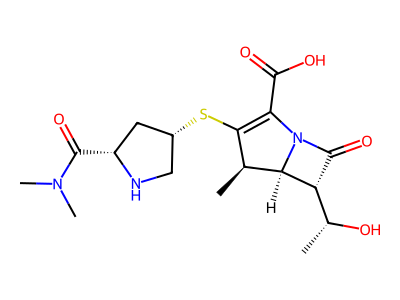

In [38]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)C(=O)N(C)C)C(=O)O)[C@@H](C)O"

mol = Chem.MolFromSmiles(smiles)

Draw.MolToImage(mol, size=(400, 300))

In [15]:
def smile_simple(molecule):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{molecule}/property/IsomericSMILES/JSON"
    response = requests.get(url)
    data = response.json()
    smiles = data["PropertyTable"]["Properties"][0]["SMILES"]
    return smiles

In [17]:
ss = []
for s in df['main_substrate']:
    try:
        smile = smile_simple(s)
        ss.append(smile)
    except:
        ss.append(None)

In [18]:
df['smiles'] = ss

In [19]:
df.to_csv('data/sabio_rk/smiles_seq_data_sabiork.csv')

# AJUSTES

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
df = pd.read_csv('data/sabio_rk/smiles_seq_data_sabiork.csv', index_col=0)
# df['smiles'].isna().sum()

df[['smiles','sequence']].drop_duplicates().dropna().shape

(645, 2)

In [12]:
df.columns

Index(['EntryID', 'pH', 'Temperature', 'kcat_km', 'kcat', 'km', 'kcat/km',
       'Organism', 'Enzyme Variant', 'Enzymename', 'Substrate', 'Reaction',
       'Product', 'PubMedID', 'Publication', 'SabioReactionID', 'UniProtKB_AC',
       'parameter.associatedSpecies', 'sequence', 'main_substrate', 'solvent',
       'smiles'],
      dtype='object')

In [13]:
df[['kcat', 'km', 'kcat/km','smiles','sequence']].drop_duplicates().dropna().shape

(22, 5)

In [14]:
df['kcat/km_'] = df['kcat'] / df['km']

In [24]:
df[['kcat', 'km', 'kcat/km_','smiles','sequence']].dropna().drop_duplicates().shape

(1311, 5)

In [25]:
df[['kcat', 'km', 'kcat/km_','smiles','sequence']].dropna().drop_duplicates().to_csv('data/sabio_rk/smiles_seq_data_sabiork_unique.csv')

In [21]:
df[df['smiles'].isna()][['main_substrate','parameter.associatedSpecies']]
df[df['main_substrate'] == 'Penicillin G']['smiles']


0       CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
25      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
28      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
31      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
34      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
37      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
40      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
43      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
61      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
80      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
89      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
98      CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
107     CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
108     CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
109     CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
110     CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
111     CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
112     CC1([C

In [22]:
trocar = {2337: 'Ceftazidime',
          425: 'Penicillin G',
          426: 'Penicillin G',
          427: 'Penicillin G',
          428: 'Penicillin G',
          429: 'Penicillin G',
          430: 'Penicillin G'
         }

for k, v in trocar.items():
    df.at[k,'main_substrate'] = v

In [23]:
df[df['smiles'].isna()]['main_substrate']

4                      6-alpha-Hydroxymethylpenicillanate
5                       6-beta-Hydroxymethylpenicillanate
6                  6-alpha-(1-Hydroxyethyl)-penicillanate
7                   6-beta-(1-Hydroxyethyl)-penicillanate
8         6-alpha-(1-Hydroxy-1-methylethyl)-penicillanate
9          6-beta-(1-Hydroxy-1-methylethyl)-penicillanate
47      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
48                3-[(Phenylacetyl)glycyl]oxybenzoic acid
54      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
55                3-[(Phenylacetyl)glycyl]oxybenzoic acid
56                      Dexamethasone-Cephem-Methotrexate
57                      Dexamethasone-Cephem-Methotrexate
58                      Dexamethasone-Cephem-Methotrexate
59                      Dexamethasone-Cephem-Methotrexate
60                      Dexamethasone-Cephem-Methotrexate
425                                          Penicillin G
426                                          Penicillin G
427           

In [24]:
trocar = {425: 'Penicillin G',
          426: 'Penicillin G',
          427: 'Penicillin G',
          428: 'Penicillin G',
          429: 'Penicillin G',
          430: 'Penicillin G'
         }
smile = df[df['main_substrate'] == 'Penicillin G']['main_substrate'][0]
for k, v in trocar.items():
    df.at[k,'smiles'] = smile

In [25]:
Ceftazidime = df[df['main_substrate'] == 'Ceftazidime']['smiles'].values[0]
df.at[2337, 'smiles'] = Ceftazidime
Ceftazidime

'CC(C)(C(=O)O)O/N=C(/C1=CSC(=N1)N)\\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC=C4)C(=O)[O-]'

In [26]:
df['smiles'].isna().sum()

np.int64(70)

In [27]:
df[df['smiles'].isna()]['main_substrate']

4                      6-alpha-Hydroxymethylpenicillanate
5                       6-beta-Hydroxymethylpenicillanate
6                  6-alpha-(1-Hydroxyethyl)-penicillanate
7                   6-beta-(1-Hydroxyethyl)-penicillanate
8         6-alpha-(1-Hydroxy-1-methylethyl)-penicillanate
9          6-beta-(1-Hydroxy-1-methylethyl)-penicillanate
47      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
48                3-[(Phenylacetyl)glycyl]oxybenzoic acid
54      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
55                3-[(Phenylacetyl)glycyl]oxybenzoic acid
56                      Dexamethasone-Cephem-Methotrexate
57                      Dexamethasone-Cephem-Methotrexate
58                      Dexamethasone-Cephem-Methotrexate
59                      Dexamethasone-Cephem-Methotrexate
60                      Dexamethasone-Cephem-Methotrexate
451                                          Ticaracillin
461                                          Ticaracillin
1081          

In [28]:
# df[df['smiles'].isna()].to_csv('data/sabio_rk/sem_smiles.csv')
df.to_csv('data/sabio_rk/smiles_seq_data_sabiork.csv')

In [29]:
################## 26/11
df = pd.read_csv('data/sabio_rk/sem_smiles.csv', index_col=0)
df.shape

(70, 22)

In [21]:
# VER SE OS OUTROS NAO FORAM CALCULADOS PRA SUBSTRATOS IGUAIS
df[df['smiles'].isna()]['main_substrate']

4                      6-alpha-Hydroxymethylpenicillanate
5                       6-beta-Hydroxymethylpenicillanate
6                  6-alpha-(1-Hydroxyethyl)-penicillanate
7                   6-beta-(1-Hydroxyethyl)-penicillanate
8         6-alpha-(1-Hydroxy-1-methylethyl)-penicillanate
9          6-beta-(1-Hydroxy-1-methylethyl)-penicillanate
47      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
48                3-[(Phenylacetyl)glycyl]oxybenzoic acid
54      3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoa...
55                3-[(Phenylacetyl)glycyl]oxybenzoic acid
56                      Dexamethasone-Cephem-Methotrexate
57                      Dexamethasone-Cephem-Methotrexate
58                      Dexamethasone-Cephem-Methotrexate
59                      Dexamethasone-Cephem-Methotrexate
60                      Dexamethasone-Cephem-Methotrexate
451                                          Ticaracillin
461                                          Ticaracillin
1081          

In [27]:
x = []
for sb in df[df['smiles'].isna()]['main_substrate'].unique():
    sm = df[df['main_substrate']==sb]['smiles']
    x.append(sm)
pd.DataFrame(x)

,4,5,6,7,8,9,47,54,48,55,56,57,58,59,60,451,461,1081,1082,1083,1096,1097,1182,1186,1191,1196,1467,1468,1469,1470,1623,1624,1626,1629,1632,1699,1746,1752,1760,1775,2265,2266,2267,2268,2269,1700,1747,1753,1761,1776,1717,1727,1737,1745,1758,1759,1821,1822,1825,1826,1829,1830,1833,1834,1837,1838,1898,2082,2200,2202
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df[df['smiles'].isna()]['main_substrate'].unique()

array(['6-alpha-Hydroxymethylpenicillanate',
       '6-beta-Hydroxymethylpenicillanate',
       '6-alpha-(1-Hydroxyethyl)-penicillanate',
       '6-beta-(1-Hydroxyethyl)-penicillanate',
       '6-alpha-(1-Hydroxy-1-methylethyl)-penicillanate',
       '6-beta-(1-Hydroxy-1-methylethyl)-penicillanate',
       '3-[2-(2-Aminothiazol-4-yl)-2-(Z)-methoxyiminoacetylglycyl]oxybenzoic acid',
       '3-[(Phenylacetyl)glycyl]oxybenzoic acid',
       'Dexamethasone-Cephem-Methotrexate', 'Ticaracillin', 'CGP-31608A',
       'CGP-17520A', '6-beta-Furylacryloylamidopenicillanic acid',
       'N-(2-Furyl)acryloylpenicillin', 'SY55555',
       '(3-Hydroxymethyl)-phenoxymethylpenicillin',
       'Benzylpenicillin methyl ester', 'Deacetylcephalosporin C lactone',
       'Carbenicillin methyl ester', 'DU-66881a', 'LJC 10,627',
       'Desacetyl cefotaxime', '2-Ethylthio-(6S,8R)hydroxyethylpeneme'],
      dtype=object)

In [92]:
import requests
m='ester'
smile_simple(m)
# phenoxymethylpenicillin : CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C
# Aminothiazol : C1=CSC(=N1)N
# oxybenzoic acid : CC1=CC2=C(/C(=C\\NC3=CC(=C(C=C3)O)C(=O)O)/C(=O)C(=C2C(C)C)O)C(=C1C4=C(C\\5=C(C=C4C)C(=C(C(=O)/C5=C\\NC6=CC(=C(C=C6)O)C(=O)O)O)C(C)C)O)O'
# phenoxymethylpenicillin : CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C
# Dexamethasone : C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C
# Methotrexate : CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)N[C@@H](CCC(=O)O)C(=O)O
# Benzylpenicillin: CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C
# lactone : CC1=CC(=O)OC2=C1C=C3C=C(OC3=C2C)C
# cefotaxime : CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)/C(=N\\OC)/C3=CSC(=N3)N)SC1)C(=O)O
# Carbenicillin : CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O)C(=O)O)C
# LJC : COC1=C(C=CC(=C1)[C@@H](CO)[C@@H](C2=CC(=C(C=C2)O)OC)O)O
# CGP : C1C[C@H]2C(=O)NCC(=O)N2C1
# ester : C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)OC=O)C)C


'C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)OC=O)C)C'

In [5]:
df = pd.read_csv('data/sabio_rk/smiles_seq_data_sabiork.csv')
df[['sequence','smiles']]

,sequence,smiles
0,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
1,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
2,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
3,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
4,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
5,MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...,NaN
6,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,NaN
7,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,NaN
8,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,NaN
9,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,NaN


# Visualização

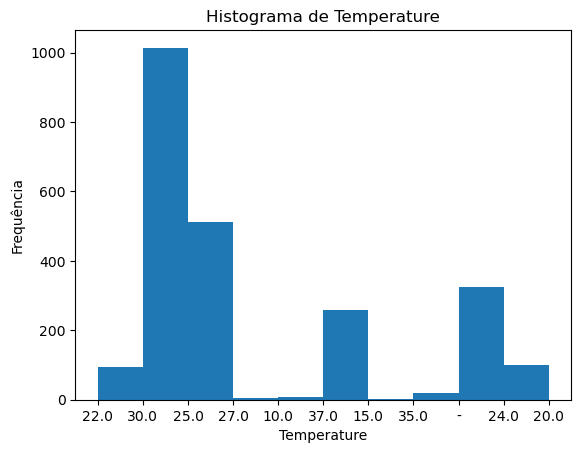

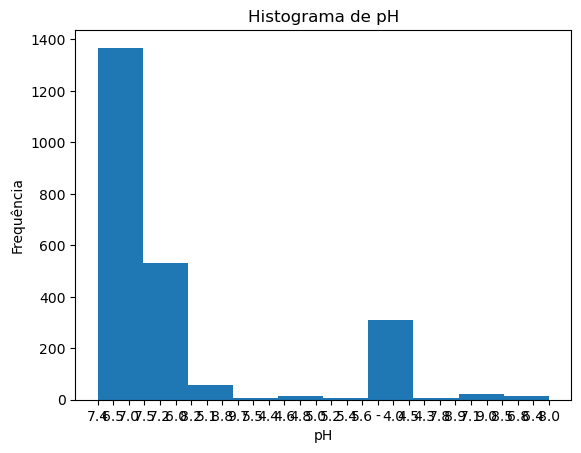

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# exemplo: carregar CSV
#df = pd.read_csv("dados.csv")
# df["Temperature"] = df["Temperature"].astype('float')
# df.at[]
# Histograma de Temperature
plt.hist(df["Temperature"].dropna())
plt.title("Histograma de Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequência")
plt.show()

# Histograma de pH
plt.hist(df["pH"].dropna())
plt.title("Histograma de pH")
plt.xlabel("pH")
plt.ylabel("Frequência")
plt.show()

In [34]:
sum(1 for x,y in zip(df['main_substrate'].values, df['parameter.associatedSpecies'].values) if str(y) == str(x))

1525